# Recommender Systems - Mini Challenge HS24

In this minichallenge we will explore a MovieLens dataset and implement several recommender systems and evaluation methods. Subsequently we will optimize these methods and compare the results. 

**Submission deadline:** 24.11.2024 18:00. 

## Guidelines for Implementation and Submission
- Code must be written in Python. The versions of all used packages must be given for reproducability.
- You may respond in English or German.
- We develop numerous algorithms ourselves. Unless explicitly stated otherwise, only the following libraries may be used in Python: numpy, matplotlib, seaborn, pandas. 
- Follow good coding practices and write modular, reusable code.
- The submitted solution must contain all codes and the results. No code may be outsourced.
- All pathes must be relative and just downloading your repo must be executable without modifications.
- Only fully running code is graded. The notebook must run sequential from start to end.
- If computation time is too long for productive prototyping and debugging work, it is recommended to reduce the dataset to a fraction of its original. However, final results should be calculated on the full dataset. 
- All plots must be fully labeled (title, axes, labels, colorbar, etc.) so that the plot can be easily understood.
- Each plot should be accompanied by a brief discussion, which explains the plot and captures the key insights that become visible.
- Only fully labeled plots with an accompanying discussion will be assessed.
- The last commit in your fork of the repo before the submission deadline counts as the submission.
- Points will be deducted if you write inconsise (Denial of service will be punished) or if I read the text that are not written for me but for the user of ChatGPT. 
- If you would like to submit and have the mini-challenge assessed, please send a short email to the subject expert (moritz.kirschmann@fhnw.ch) within 2 days after submission.
- Please do not delete, duplicate, or move the existing cells. This leads to problems during the correction. However, you may add as many additional cells as you like.

## Exercises

### Exercise 1 - A deep exploration of the dataset (17 points)
We will work with a subset of the MovieLens dataset. This subset is located under ``data/ml-latest-small``. Read the ``README.txt``carefully. 
Open the files. 

a) Describe the available data.

Die Daten von MovieLens, einem Filmempfehlungsdienst, beschreiben 5-Sterne-Bewertungen von Filmen. Er enthält 100’836 Bewertungen und 3’683 Tags-Anwendungen für 9’742 Filme. Diese Daten wurden von 610 Nutzern zwischen dem 29. März 1996 und dem 24. September 2018 erstellt. Der Datensatz wurde am 26. September 2018 erstellt.
Die Nutzer wurden nach dem Zufallsprinzip für die Aufnahme ausgewählt. Alle ausgewählten Nutzer hatten mindestens 20 Filme bewertet. Es sind keine demografischen Informationen enthalten. Jeder Nutzer wird durch eine ID repräsentiert, und es werden keine weiteren Informationen bereitgestellt.
Die Daten sind in den Dateien «links.csv», «movies.csv», «ratings.csv» und «tags.csv» enthalten. 
Die Daten:
•	ratings.csv: Enthält alle Bewertungen. Jede Zeile repräsentiert eine Bewertung eines Films durch einen Benutzer und hat das Format: «userId», «movieId», «rating» und «timestamp». Die Bewertungen erfolgen auf einer 5-Sterne-Skala mit Abstufungen von einem halben Stern (0,5 Sterne - 5,0 Sterne).
•	tags.csv: Enthält alle tags (Etikett). Jede Zeile repräsentiert ein tag, das von einem Benutzer auf einen Film angewendet wurde, und hat das Format: «userId», «movieId», «tag» und «timestamp». Tags sind vom Benutzer erstellte Metadaten zu Filmen, wie beispielsweise der Hauptdarsteller oder ein Wort das beschreibt um was es im Gilm geht (bsp. Wedding wenn im Film geheiratet wird).
•	movies.csv: Enthält Filminformationen. Jede Zeile repräsentiert einen Film und hat das Format: «movieId», «title» und «genres». Die Genres sind eine durch Pipes ( | ) getrennte Liste, welche genres vom Film alles abgedeckt werden.
•	links.csv: Enthält Bezeichner zur Verknüpfung mit anderen Quellen von Filmdaten. Jede Zeile repräsentiert einen Film und hat das Format: «movieId», «imdbId» (imbdId = Internet Movie Database ID) und «tmdbId» (tmdbid = The Movie Database ID). Diese IDs helfen dabei, einen Film eindeutig auf verschiedenen Plattformen zu identifizieren. Wenn man also eine bestimmte Filminformation abrufen möchte, kann man die jeweilige ID nutzen, um den Film auf einer der Plattformen zu finden.

Programmiertechnisch wird der Datensatz im Abschnitt unter dem Markdown "a) Describe the available data" gezeigt.


b) Find and fix bad data (e.g. duplicates, missing values, etc.).

Generate lists of

c) - Top 20 movies by average rating

d) - Top 20 movies by number of views

e) What is the range of the ratings? 

f) Which genre has be rated how many times?

g) How sparse is the User Rating Matrix?

Plot the following:

h) How many users have rated how many movies

i) Which rating is given how often on average

j) Which rating is given how often on average per genre

k) The rating distributions of 10 random movies

l) The rating distributions of 3 movies that you have watched

m) How many users give which average rating

n) How often a movie was rated as a function of average rating

o) A heatmap of the User Item Matrix

p) A heatmap of the User Item Matrix for the 100 most rated movies for the 50 users with most ratings


In [10]:
import pandas as pd
from pathlib import Path
from itertools import groupby
import numpy as np
import os
#Damit die Liste im Output besser aussieht brauche ich pprint
import pprint
import matplotlib.pyplot as plt
import seaborn as sns

#Damit die Liste im Output besser aussieht brauche ich pprint
import pprint## Datensätze werden zum ersten Mal eingelesen

In [86]:
#Datensätze einlesen
output_dir = Path("Data\ml-latest-small")
csv_path_links = output_dir / "links.csv"
csv_path_movies = output_dir / "movies.csv"
csv_path_ratings = output_dir / "ratings.csv"
csv_path_tags = output_dir / "tags.csv"
links_raw = pd.read_csv(csv_path_links)
movies_raw = pd.read_csv(csv_path_movies)
ratings_raw = pd.read_csv(csv_path_ratings)
tags_raw = pd.read_csv(csv_path_tags)

## a) Describe the available data.

In [41]:
#Aufgabe A
def data_describe(df):
    print(f"{df} Datensatz")
    print(df.info())

data_describe(links_raw)

      movieId   imdbId    tmdbId
0           1   114709     862.0
1           2   113497    8844.0
2           3   113228   15602.0
3           4   114885   31357.0
4           5   113041   11862.0
...       ...      ...       ...
9729   193581  5476944  432131.0
9730   193583  5914996  445030.0
9731   193585  6397426  479308.0
9732   193587  8391976  483455.0
9733   193609   101726   37891.0

[9734 rows x 3 columns] Datensatz
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9734 entries, 0 to 9733
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9734 non-null   int64  
 1   imdbId   9734 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.3 KB
None


In [42]:
data_describe(movies_raw)

      movieId                                      title  \
0           1                           Toy Story (1995)   
1           2                             Jumanji (1995)   
2           3                    Grumpier Old Men (1995)   
3           4                   Waiting to Exhale (1995)   
4           5         Father of the Bride Part II (1995)   
...       ...                                        ...   
9737   193581  Black Butler: Book of the Atlantic (2017)   
9738   193583               No Game No Life: Zero (2017)   
9739   193585                               Flint (2017)   
9740   193587        Bungo Stray Dogs: Dead Apple (2018)   
9741   193609        Andrew Dice Clay: Dice Rules (1991)   

                                           genres  
0     Adventure|Animation|Children|Comedy|Fantasy  
1                      Adventure|Children|Fantasy  
2                                  Comedy|Romance  
3                            Comedy|Drama|Romance  
4                  

In [43]:
data_describe(ratings_raw)

        userId  movieId  rating   timestamp
0            1        1     4.0   964982703
1            1        3     4.0   964981247
2            1        6     4.0   964982224
3            1       47     5.0   964983815
4            1       50     5.0   964982931
...        ...      ...     ...         ...
100831     610   166534     4.0  1493848402
100832     610   168248     5.0  1493850091
100833     610   168250     5.0  1494273047
100834     610   168252     5.0  1493846352
100835     610   170875     3.0  1493846415

[100836 rows x 4 columns] Datensatz
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None


In [44]:
data_describe(tags_raw)

      userId  movieId               tag   timestamp
0          2    60756             funny  1445714994
1          2    60756   Highly quotable  1445714996
2          2    60756      will ferrell  1445714992
3          2    89774      Boxing story  1445715207
4          2    89774               MMA  1445715200
...      ...      ...               ...         ...
3678     606     7382         for katie  1171234019
3679     606     7936           austere  1173392334
3680     610     3265            gun fu  1493843984
3681     610     3265  heroic bloodshed  1493843978
3682     610   168248  Heroic Bloodshed  1493844270

[3683 rows x 4 columns] Datensatz
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
d

## b) Find and fix bad data (e.g. duplicates, missing values, etc.)

In [108]:
#Aufgabe B
# Pfade der Datensätze um sicherzugehen, dass ich die nehme, die noch unberührt sind
files = {
    "links": "Data/ml-latest-small/links.csv",
    "movies": "Data/ml-latest-small/movies.csv",
    "ratings": "Data/ml-latest-small/ratings.csv",
    "tags": "Data/ml-latest-small/tags.csv",
}

# Funktion zur Bereinigung und Standardisierung von CSV-Daten
def clean_dataframe(df):
    # Entfernen von unnötigen Anführungszeichen, die den gesamten Wert umschliessen, da mir auffiel, dass es im Datensatz Movies dieses Problem gab
    def clean_string(x):
        if isinstance(x, str):
            # Entfernen von führenden und nachfolgenden Anführungszeichen
            x = x.strip("'\"")
        return x

    df = df.map(clean_string)
    
    # mögliche "<unset>" durch NaN ersetzen
    df = df.replace("<unset>", np.nan)
    
    # Überprüfen und Anpassen des Datentyps
    for column in df.columns:
        # Versuchen, den Datentyp zu inferieren und zu casten, falls der Datentyp nicht konsistent ist
        if df[column].dtype == 'object':
            # Überprüfen, ob die Spalte nur numerische Werte enthält
            try:
                df[column] = pd.to_numeric(df[column], errors='raise')
            except ValueError:
                pass  # Wenn es nicht konvertierbar ist, behalten wir den ursprünglichen Datentyp bei
    
    return df

# Lade Daten in DataFrames und stelle sicher, dass die erste Zeile als Spaltennamen verwendet wird
dfs = {}
for name, path in files.items():
    df = pd.read_csv(path, header=None)
    
    # Setze die erste Zeile als Spaltennamen
    df.columns = df.iloc[0]
    
    # Entferne die erste Zeile, da sie jetzt die Spaltenüberschriften sind
    df = df.drop(0, axis=0).reset_index(drop=True)
    
    dfs[name] = df

# Anwenden der Reinigung auf alle DataFrames
dfs_cleaned = {name: clean_dataframe(df) for name, df in dfs.items()}

# Zielordner definieren um die neuen DF von den alten getrennt zu speichern
output_dir = "Data/filtered_data"

# Sicherstellen, dass der Zielordner existiert
os.makedirs(output_dir, exist_ok=True)

for name, df in dfs_cleaned.items():
    # Berechnen der Anzahl der Duplikate und NA aus den gefilterten Daten um zu zeigen, dass sie gut gefiltert wurden
    duplicates_count = df.duplicated().sum()
    na_count = df.isna().sum()
    # Ausgabe der Anzahl der Duplikate
    print(f"Anzahl der Duplikate im {name}-Datensatz: {duplicates_count}\n")
    # Ausgabe der Anzahl der NA
    print(f"Anzahl der NA im {name}-Datensatz: {na_count}\n")
    
    # Speichern der bereinigten DataFrames als CSV-Dateien
    df.to_csv(os.path.join(output_dir, f"{name}_cleaned.csv"), index=False)

print("Bereinigte Daten wurden gespeichert.")

Anzahl der Duplikate im links-Datensatz: 0

Anzahl der NA im links-Datensatz: 0
movieId    0
imdbId     0
tmdbId     0
dtype: int64

Anzahl der Duplikate im movies-Datensatz: 0

Anzahl der NA im movies-Datensatz: 0
movieId    0
title      0
genres     0
dtype: int64

Anzahl der Duplikate im ratings-Datensatz: 0

Anzahl der NA im ratings-Datensatz: 0
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Anzahl der Duplikate im tags-Datensatz: 0

Anzahl der NA im tags-Datensatz: 0
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

Bereinigte Daten wurden gespeichert.


In [6]:
#Gefilterte Datensätze wieder den Variablen zuweisen:
output_dir = Path("Data/filtered_data")
csv_path_links = output_dir / "links_cleaned.csv"
csv_path_movies = output_dir / "movies_cleaned.csv"
csv_path_ratings = output_dir / "ratings_cleaned.csv"
csv_path_tags = output_dir / "tags_cleaned.csv"
links = pd.read_csv(csv_path_links)
movies = pd.read_csv(csv_path_movies)
ratings = pd.read_csv(csv_path_ratings)
tags = pd.read_csv(csv_path_tags)

## c) Generate a lis of Top 20 movies by average rating

In [134]:
#gruppiert die Filme und berechnet den Bewertungsdurchschnitt. Zusätzlich, nehme ich nur die höchsten 20 und wandle es zu einem DF um, damit ich es mergen kann
top_20_movies = ratings.groupby("movieId")["rating"].mean().sort_values(ascending=False).head(20).reset_index()

liste_top_20 = list(top_20_movies.merge(movies[["movieId", "title"]], on="movieId", how="left")["title"])
pprint.pprint(liste_top_20)

["Won't You Be My Neighbor? (2018)",
 'Jane Eyre (1944)',
 'Rain (2001)',
 'Goodbye Charlie (1964)',
 'Sorority House Massacre (1986)',
 'Slumber Party Massacre III (1990)',
 'Slumber Party Massacre II (1987)',
 'True Stories (1986)',
 'Moonlight',
 'Tom Segura: Mostly Stories (2016)',
 'All Yours (2016)',
 'Valet, The (La doublure) (2006)',
 'Odd Life of Timothy Green, The (2012)',
 'Lady Jane (1986)',
 'Open Hearts (Elsker dig for evigt) (2002)',
 'SORI: Voice from the Heart (2016)',
 'Tenchi Muyô! In Love (1996)',
 'A Flintstones Christmas Carol (1994)',
 'Delirium (2014)',
 'Snowflake, the White Gorilla (2011)']


## d) Generate a list of Top 20 movies by number of views
Ich gehe hier davon aus, dass ein view einer Bewertung entspricht, da ein Film für eine Bewertung zumindest einmal gesehen werden muss.

In [135]:
#gruppiert die Filme und summiert die ANzahl Bewertungen. Zusätzlich, nehme ich nur die höchsten 20 und wandle es zu einem DF um, damit ich es mergen kann
top_20_movies_by_view = ratings.groupby("movieId")["rating"].count().sort_values(ascending=False).head(20).reset_index()

liste_top_20_by_view = list(top_20_movies_by_view.merge(movies[["movieId", "title"]], on="movieId", how="left")["title"])
pprint.pprint(liste_top_20_by_view)

['Forrest Gump (1994)',
 'Shawshank Redemption, The (1994)',
 'Pulp Fiction (1994)',
 'Silence of the Lambs, The (1991)',
 'Matrix, The (1999)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Jurassic Park (1993)',
 'Braveheart (1995)',
 'Terminator 2: Judgment Day (1991)',
 "Schindler's List (1993)",
 'Fight Club (1999)',
 'Toy Story (1995)',
 'Star Wars: Episode V - The Empire Strikes Back (1980)',
 'American Beauty (1999)',
 'Usual Suspects, The (1995)',
 'Seven (a.k.a. Se7en) (1995)',
 'Independence Day (a.k.a. ID4) (1996)',
 'Apollo 13 (1995)',
 'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) '
 '(1981)',
 'Lord of the Rings: The Fellowship of the Ring, The (2001)']


## e) What is the range of the ratings?

In [144]:
list_of_ratings = ratings["rating"].drop_duplicates().sort_values(ascending=False).tolist()
print(f"Die Spannweite der Bewertungen für die Filme liegt zwischen: {list_of_ratings[-1]} bis {list_of_ratings[0]}")

Die Spannweite der Bewertungen für die Filme liegt zwischen: 0.5 bis 5.0


## f) Which genre has be rated how many times?

In [160]:
#genres aus movies in ratings datensatz einbauen
ratings_mit_gernes = ratings.merge(movies[["movieId", "genres"]], on="movieId", how="left")

# Die Genre sind teilweise mit | getrennt, was sich, wenn es nicht aufgesplittet wird, nicht sauber zählen lässt, deshalb muss es hier aufgesplittet werden
ratings_mit_gernes_exploded = ratings_mit_gernes.assign(genre=df["genres"].str.split("|")).explode("genre")

#Anzahl der Bewertungen pro Genre zählen
genre_counts = ratings_mit_gernes_exploded["genre"].value_counts().reset_index(name="count")

pprint.pprint(genre_counts)


                 genre  count
0                Drama  41928
1               Comedy  39053
2               Action  30635
3             Thriller  26452
4            Adventure  24161
5              Romance  18124
6               Sci-Fi  17243
7                Crime  16681
8              Fantasy  11834
9             Children   9208
10             Mystery   7674
11              Horror   7291
12           Animation   6988
13                 War   4859
14                IMAX   4145
15             Musical   4138
16             Western   1930
17         Documentary   1219
18           Film-Noir    870
19  (no genres listed)     47


## g) How sparse is the User Rating Matrix?

In [40]:
# Anzahl der eindeutigen Benutzer und Filme
num_users = ratings["userId"].nunique()
num_movies = ratings["movieId"].nunique()

# Anzahl der vorhandenen Bewertungen
num_ratings = len(ratings)

# Gesamtanzahl der möglichen Bewertungen
total_mgl_ratings = num_users * num_movies


# Berechnung der spärlichkeit
spärlichkeit = 1 - (num_ratings / total_mgl_ratings)

print(f"Es fehlen rund {round(spärlichkeit,4) *100}% aller möglichen Bewertungen")

Es fehlen rund 98.3% aller möglichen Bewertungen


## h) How many users have rated how many movies

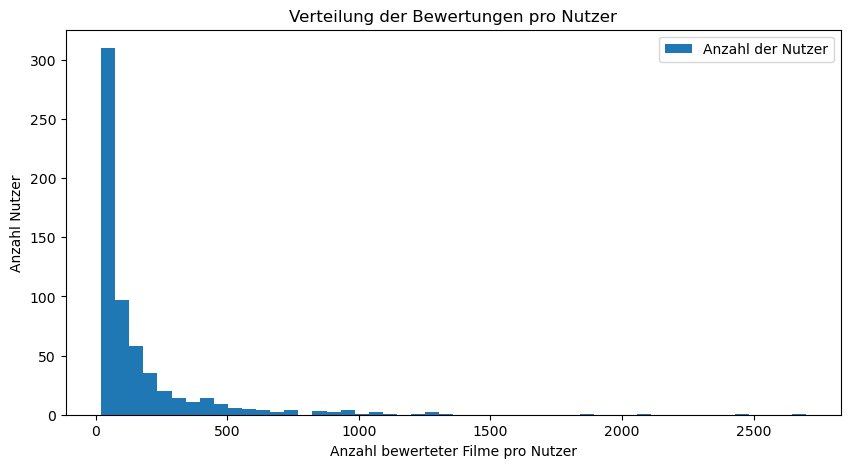

In [27]:
ratings_per_user = ratings.groupby("userId")["rating"].count().sort_values(ascending=False).reset_index()

plt.figure(figsize=(10, 5))
plt.hist(ratings_per_user["rating"], bins=50, label="Anzahl der Nutzer")
plt.xlabel("Anzahl bewerteter Filme pro Nutzer")
plt.ylabel("Anzahl Nutzer")
plt.title("Verteilung der Bewertungen pro Nutzer")
plt.legend()  # Funktioniert jetzt!
plt.show()

## i) Which rating is given how often on average

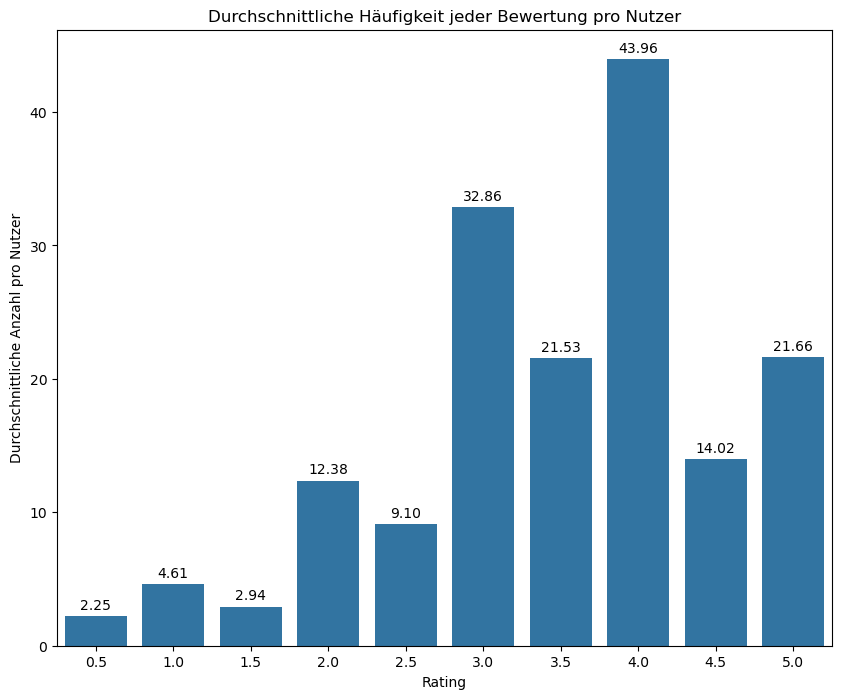

In [54]:
ratings_avg_per_user = ratings.groupby("rating")['movieId'].count() / num_users

plt.figure(figsize=(10,8))
sns.barplot(x=ratings_avg_per_user.index, y=ratings_avg_per_user.values)

# Achsen und Titel
plt.xlabel("Rating")
plt.ylabel("Durchschnittliche Anzahl pro Nutzer")
plt.title("Durchschnittliche Häufigkeit jeder Bewertung pro Nutzer")

# Werte über die Balken schreiben (i = index pos auf x achse, v = value pos auf y achse)
for i, v in enumerate(ratings_avg_per_user.values):
    plt.text(i, v + 0.5, f"{v:.2f}", ha='center', fontsize=10)

plt.show()

### Exercise 2 - Building a baseline RS (7 points)
In this exercise we will build a baseline RS and functions to calculate fundamental performance metrics. 

Build the following baseline RS to predict Top-N (default N=20):
1. In reference to the book *Collaborative Filtering Recommender Systems by Michael D. Ekstrand, John T. Riedl and Joseph A. Konstan* (p. 91ff) implement the baseline predictor $$ b_{u,i}= \mu +b_u +b_i $$ with the regularized user and item average offsets: $$ b_u = \frac{1}{|I_u| + \beta_u} \sum_{i \in I_u} (r_{u,i} - \mu) $$ and $$ b_i = \frac{1}{|U_i| + \beta_i} \sum_{u \in U_i} (r_{u,i} - b_u - \mu) . $$ Build a recommender system upon this baseline predictor. Set the default damping factors $\beta_u$ and $\beta_i$ both to 20.
2. Build a RS that recommends based on *random* recommendations.  

Output the recommendations for three example users (Ids 1, 3 and 7) and the default parameters. Give the titles of the recommended movies and their predicted scores not just their Ids.

### Exercise 3 - Evaluation methods (12 points)
Split the data into train/validation set and a separate test set. This test set shall contain the first 20% of the users and shall not be used at all before exercise 10. With the remaining 80% do the following: 
Implement a function to partition your dataset for an offline evaluation based on holding out of random users with 5x cross validation with a 80/20 train/validation split. Within the validation set implement a masking with *all but n* approach. 
See page 2942 of https://jmlr.csail.mit.edu/papers/volume10/gunawardana09a/gunawardana09a.pdf for details on this approach. 

Choose the number of masked items n reasonably and explain your considerations.

Implement functions to calculate the following metrics:
- *Mean Absolute Error (MAE)* 
- *Root Mean Square Error (RMSE)*
- *Precision@N* with default $N=15$ and relevance threshold 4.0 stars.
- *Recall@N* with default $N=15$ and relevance threshold 4.0 stars.

Explain each of these. How does the relevance threshold influence the metrics? How would you choose this parameter?

Note: For the last two metrics use the definitions from https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54 with one exception: In case of the denominator being zero, set the metric to 0. 

### Exercise 4 - Optimize hyperparameters of baseline RS (6 points)
Optimize the hyperparameters $\beta_u$ and $\beta_i$ for the baseline RS from exercise 2 based on the RMSE metric. To save computation time find a reasonable maximum value for the betas. Explain your approach and your solution.
Plot the MAE, RMSE, Precision@N, Recall@N as functions of the betas.

Which metric would you use for hyperparameter tuning? Explain your decision.

### Exercise 5 - Collaborative filtering; item-based and user-based (12 points)
In this exersise we will build several different collaborative-filtering RS based on nearest neighbour technique, both in terms of item and user. 

Implement:
1. a RS based on the $K$ most similar items (K nearest neighbours). Similarity shall be calculated based on *cosine similarity*. 
2. a RS based on the $K$ most similar items (K nearest neighbours). Similarity shall be calculated based on *Pearson Correlation Coefficienct*. 
3. a RS based on the $K$ most similar users (K nearest neighbours). Similarity shall be calculated based on *cosine similarity*. 
4. a RS based on the $K$ most similar users (K nearest neighbours). Similarity shall be calculated based on *Pearson Correlation Coefficienct*. 

Each should have a default $K$ of 30.

Explain how you handle NaN values in the user rating matrix when computing similarities? What other preparations are useful such as normalization and mean centering?

Describe the two similarity metrics.

Show the top 20 recommended items for user ids 3, 5 and 7.


### Exercise 6 - Optimize hyperparameter $K$ (6 points)
Optimize the hyperparameter $K$ for all RS from the prior exercise optimizing for minimal RMSE. 
For each RS plot RMSE, Precision@N and Recall@N as a function of $K$. 

Compare the results of these four RS on the 3 example users. Do the results match your expectation? Describe.

### Exercise 7 - Model-based RS: SVD (10 points)
In this exercise we will use the unsupervised method *singular value decomposition (SVD)* from the python package *surprise* (https://surpriselib.com, documentation https://surprise.readthedocs.io/en/stable/matrix_factorization.html). SVD can compress much of the information of a matrix in few components.  

a)Run the SVD RS and show the results on the three example users from exercise 2. Explain how this algorithm works.

Note: A very good general introduction to SVD is this youtube video series starting with https://www.youtube.com/watch?v=gXbThCXjZFM&t=337s . See *Collaborative filtering recommender systems* by Ekstrand et al. *Mining of massive datasets* by Leskovec, Kapitel 11 (2020) and, *Recommender systems: The textbook*, by Aggarwal, chapter 3

b) We explore now what latent factors SVD has learned. Generate three sorted lists: Sort the items by their biggest, second biggest and third biggest singlular value component. For each list print the top and bottom 20 items. What do you observe?

### Exercise 8 - Optimize hyperparameter $k$ or `n_factors` (4 points)
Optimize the hyperparameter, representing the number of greatest SVD components used for the truncated reconstruction of the user item matrix, to minimize RMSE.
Plot RMSE, Precision@N and Recall@N as a function of this hyperparameter. Finally output all performance metrics from exercise 3 for the optimal $k$ value.

### Exercise 9 - Everything goes (30 points)
In this exercise you can explore different methods of RS. You are not limited what methods you apply. You can try to improve the methods from the earlier exercises by modifiying them or generating ensemble or hybrid RS. Also you could train deep neural networks, use NLP methods, use the available links to imdb available in the dataset to further enrich the dataset or find an obscure method by someone else on Github. 
Document what your inspirations and sources are and describe the method conceptually. 

**Build and optimize in total *three* different methods. The last one has the additional requirement that it should increase the diversity of the recommendations in order to minimize filter bubbles.**

**Important: If you use the work of someone else you must be able to explain the method conceptually during the defense MSP.** 

Output the performance metrics of exercise 3. 

### Exercise 10 - Compare all RS that you build in this challenge (8 points)
a) Compile a table with the performance metrics of exercise 3 for all RS from this MC (Make sure to include the baseline RS and random RS) on the test set defined in exercise 3. Also generate comparative plots. Discuss.

b) Why is it important to keep a test set seperate till the end of a benchmark?

**Read the Guidelines for Implementation and Submission one more time.**